# Jupyter Notebook demonstrating VCO model functions
Implementation occurs in `vco.py`

In [1]:
import vco
import numpy as np
import numpy.random as nprd
import matplotlib.pyplot as plt

%matplotlib inline

## Demonstrate VCO_model class
Initialize a 6x12 VCO matrix with a ringsize of 12 and phase noise of 0.5 to show `VCO_model` instantiation:

In [2]:
numrow, numcol = 6, 12
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(numrow)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(numcol))/numcol 
phz_noise = 1

VCOmat = [[vco.VCO_model(ringsize, rhos[i], thetas[j], phz_noise) \
           for j in range(numcol)] for i in range(numrow)]

Next, demonstrate the `__repr__` function by printing the first two rows and columns of the matrix:

In [3]:
for i in range(2):
    for j in range(2):
        print(VCOmat[i][j])

VCO [N=12, (rho, theta)=(0.14, 3.141593), phi_n=1]
VCO [N=12, (rho, theta)=(0.14, 3.665191), phi_n=1]
VCO [N=12, (rho, theta)=(0.24248711305964282, 3.141593), phi_n=1]
VCO [N=12, (rho, theta)=(0.24248711305964282, 3.665191), phi_n=1]


Now, show the instantaneous angular frequency of VCOs given a constant velocity circular path; we expect 12 shifted tuning curves:

In [4]:
# Create a simulated running path (constant velocity, running around in a circle)
d = np.arange(0, 2 * np.pi, 0.001)
v = 14*np.ones_like(d)
pol_path = np.asarray([v,d]).T

x,y = vco.pol2cart(v,d)

tune = np.zeros((d.shape[0],ringsize))
for cell in range(ringsize):
    tune[:,cell] = VCOmat[0][0].get_angular_freq(cell,pol_path)

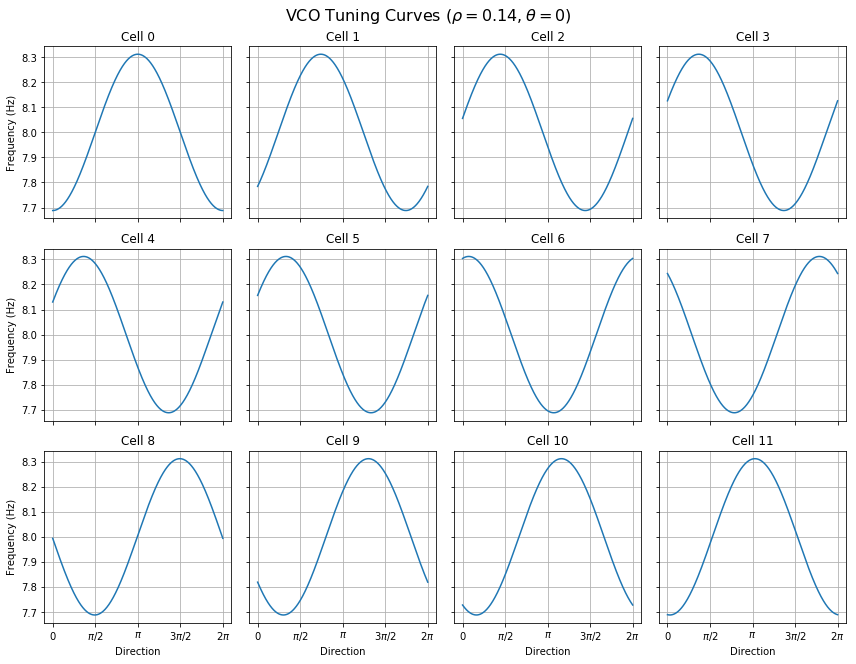

In [5]:
fig, axs = plt.subplots(3,4,sharex=True,sharey=True,figsize=(12,9))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for cell in range(ringsize):
    axs[cell].plot(d,tune[:,cell])
    axs[cell].set_title('Cell %d' % cell)
    axs[cell].grid()
    
    if not (cell) % 4:
        axs[cell].set_ylabel('Frequency (Hz)')
    if cell >= 8:
        axs[cell].set_xlabel('Direction')
        axs[cell].set_xticks([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi])
        axs[cell].set_xticklabels(["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"]);

plt.tight_layout()
plt.suptitle(r"VCO Tuning Curves ($\rho = 0.14, \theta = 0$)",fontsize=16,y=1.02);

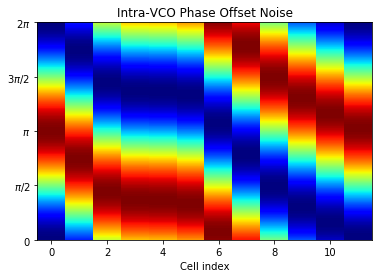

In [6]:
plt.imshow(tune, aspect='auto',cmap='jet',origin='lower')
plt.title('Intra-VCO Phase Offset Noise')
plt.xlabel('Cell index')
plt.yticks([0., .5*np.pi*1000, np.pi*1000, 1.5*np.pi*1000, 2*np.pi*1000],
          ["$0$", "$\pi/2$", "$\pi$","$3\pi/2$", "$2 \pi$"]);

## Demonstrate connecting multiple VCOs with a weight matrix
Heuristically choose 1000 grid cell connectivity patterns. The algorithm is as follows:

* Randomly choose row: 1 in 6
* Randomly choose columns: 3 in 12
* At each point (row, columns[0:2]), choose cell: 1 in 12

In [7]:
n_inputs = 3
n_mats = 1000
rd_wts = np.full([numrow,numcol,n_mats], np.nan)

for mat in range(n_mats):
    random_row = nprd.randint(numrow)
    random_cols = np.arange(numcol)
    nprd.shuffle(random_cols)

    for col in random_cols[:n_inputs]:
        rd_wts[random_row, col, mat] = nprd.randint(ringsize)

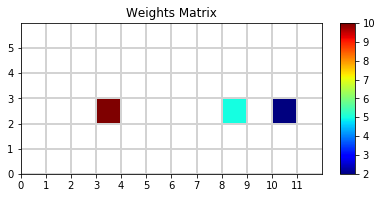

In [8]:
vco.plot_weights(rd_wts[:,:,34])

Now, calculate the random "grid" outputs from each of these weights matrices and plot:

In [9]:
size = 10
rd_outputs = np.zeros((10*size, 10*size, n_mats, 2))
for i in range(n_mats):
    norm_env, env_prod = vco.matrix_sum(VCOmat, rd_wts[:,:,i], size)
    rd_outputs[:,:,i,0] = norm_env
    rd_outputs[:,:,i,1] = env_prod

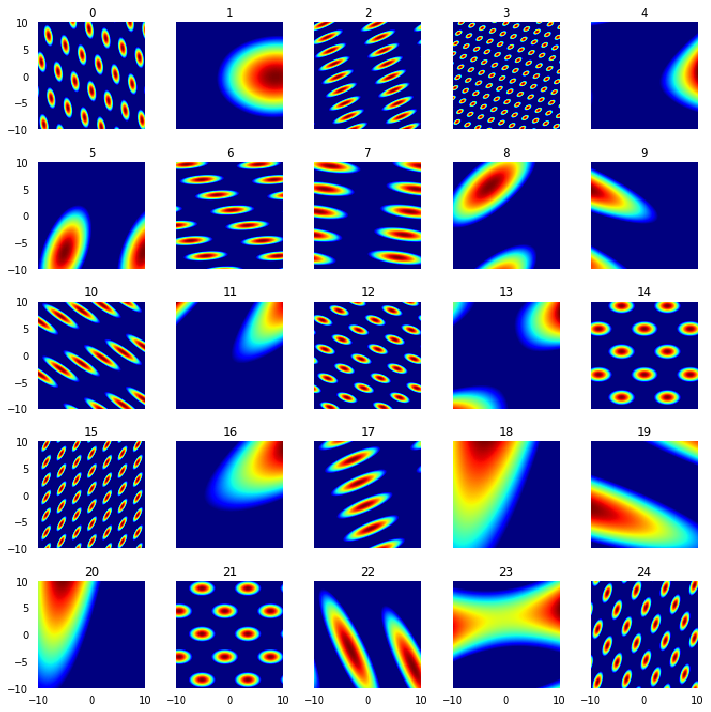

In [10]:
vco.plot_many(rd_outputs[:,:,:25,0],size)